## Notebook for analysis of allele biases

The parameters 'threshold', 'folder' and 'chromosome' can be changed manually. 

In [2]:
import math

import matplotlib.pyplot as plt
import pandas as pd
from bioinfokit import analys, visuz
from scipy.stats import binomtest 
from statsmodels.stats import multitest
from qmplot import manhattanplot

pd.set_option("display.max_columns", None)

Read thresholded dataframe with LOH positions

In [3]:
threshold = 10
folder = "LOH_pos_thresholded"
readfile = f"/home/junkhann/daten/{folder}/LOH_positions_threshold_{threshold}.tsv.gz"

In [4]:
df = pd.read_csv(readfile, sep="\t", compression="gzip")
len(df)

7614506

In [5]:
def get_number_ref_alleles(entry: str) -> int:
    return entry.split(",")[0]

In [6]:
def get_number_alt_alleles(entry: str) -> int:
    return entry.split(",")[1]

In [7]:
# tumor_genotype field is "ref,alt"
df["n_ref_alleles"] = df["tumor_genotype"].apply(get_number_ref_alleles)
df["n_alt_alleles"] = df["tumor_genotype"].apply(get_number_alt_alleles)

In [8]:
df.head()

,#CHROM,pos_x,REF,ALT,INFO,sample_control,sample_tumor,start,end,genotype,TCN,PID,normal_genotype,tumor_genotype,quality_score,reads_normal,reads_tumor,CELL_TYPE,RSID,GENE,GENE_ID,A1,A2,A2_FREQ_ONEK1K,A2_FREQ_HRC,position_code,pos_y,position_count,n_ref_alleles,n_alt_alleles
0,3,116741503,G,T,BRF=0.3;FR=0.2502;HP=1;HapScore=1;MGOF=5;MMLQ=...,"0/1:-68.95,0,-82.05:5:99:49:24","0/0:0,-2.64,-115.1:2:26:36:3",116664052,116765897,1:0,1.0,4100314,"1,1","1,0",99.000000,49,36,CD4 Naive/Central memory T cell,rs62266231,{'RP11-384F7.1'},{'ENSG00000243276'},G,T,0.40140,0.394672,3-116741503,3-116741503,20,1,0
1,3,116741503,G,T,BRF=0.3;FR=0.2502;HP=1;HapScore=1;MGOF=5;MMLQ=...,"0/1:-68.95,0,-82.05:5:99:49:24","0/0:0,-2.64,-115.1:2:26:36:3",116664052,116765897,1:0,1.0,4100314,"1,1","1,0",99.000000,49,36,CD4 Naive/Central memory T cell,rs75148451,{'RP11-384F7.1'},{'ENSG00000243276'},C,T,0.15285,0.141993,3-116741503,3-116741503,20,1,0
2,3,116741503,G,T,BRF=0.4;FR=0.5;HP=1;HapScore=1;MGOF=1;MMLQ=34;...,"0/1:-60.47,0,-30.27:1:99:32:20","0/1:-72.47,0,-17.97:1:99:29:22",116599128,116949659,2:0,2.0,4104105,"1,1","0,2",43.209753,32,29,CD4 Naive/Central memory T cell,rs62266231,{'RP11-384F7.1'},{'ENSG00000243276'},G,T,0.40140,0.394672,3-116741503,3-116741503,20,0,2
3,3,116741503,G,T,BRF=0.4;FR=0.5;HP=1;HapScore=1;MGOF=1;MMLQ=34;...,"0/1:-60.47,0,-30.27:1:99:32:20","0/1:-72.47,0,-17.97:1:99:29:22",116599128,116949659,2:0,2.0,4104105,"1,1","0,2",43.209753,32,29,CD4 Naive/Central memory T cell,rs75148451,{'RP11-384F7.1'},{'ENSG00000243276'},C,T,0.15285,0.141993,3-116741503,3-116741503,20,0,2
4,3,116741503,G,T,BRF=0.2;FR=0.5001;HP=1;HapScore=1;MGOF=1;MMLQ=...,"0/1:-59,0,-70.35:1:99:37:16","0/1:-78.38,0,-3.28:0:33:24:22",101685018,127432248,5:0,5.0,4111337,"1,1","0,5",99.000000,37,24,CD4 Naive/Central memory T cell,rs62266231,{'RP11-384F7.1'},{'ENSG00000243276'},G,T,0.40140,0.394672,3-116741503,3-116741503,20,0,5


Perform binomial test for each position

In [9]:
def get_p_value(df_position: pd.DataFrame) -> float:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_alt_alleles"] == "0"]
    k = len(df_loss_ref)
    result = binomtest(k=k, n=n, p=0.5, alternative="two-sided")
    return result.pvalue

In [10]:
p_values = df.groupby("position_code").apply(get_p_value)

Plot p-values

<Axes: title={'center': 'Distribution of p-values'}, xlabel='p-value', ylabel='Frequency'>

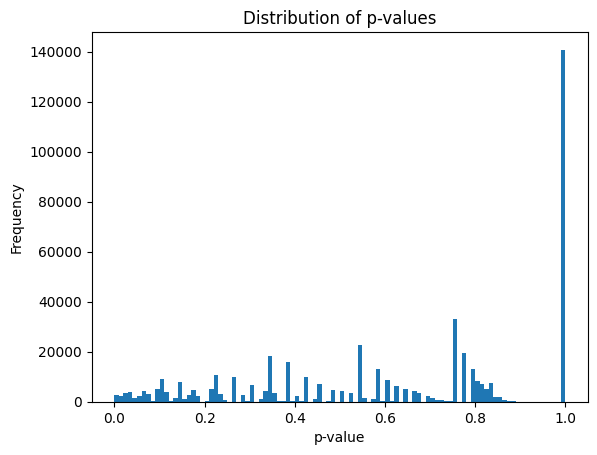

In [11]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")

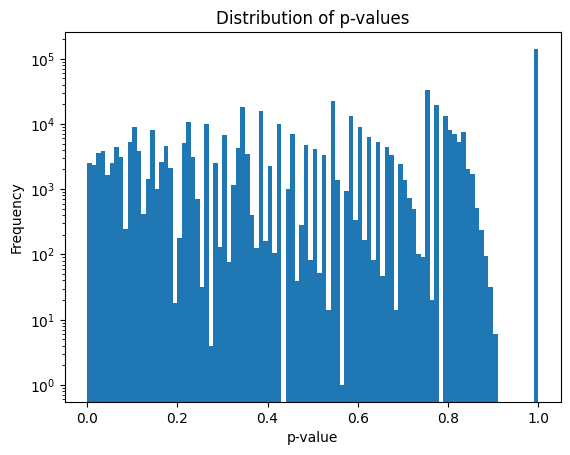

In [12]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")
plt.yscale("log")

Benjamini-Hochberg correction for multiple testing

In [13]:
rejected, adjusted_p_values, _, _ = multitest.multipletests(p_values, method='fdr_bh')

Text(0.5, 1.0, 'Distribution of p-values (adjusted by Benjamini-Hochberg correction)')

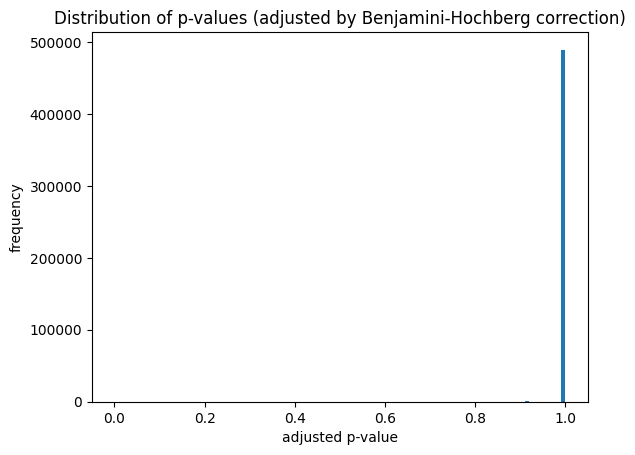

In [14]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")

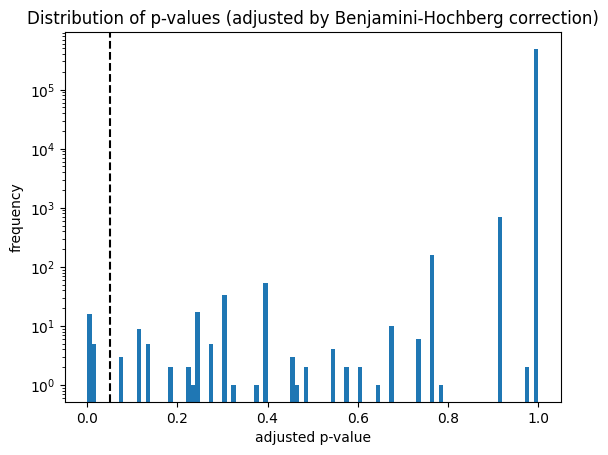

In [15]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")
plt.yscale("log")
plt.axvline(x=0.05, linestyle="dashed", color="black")

Visualisation: Manhattan plot

In [16]:
df_manhattan = pd.DataFrame(p_values).reset_index()
df_manhattan["P"] = adjusted_p_values
df_manhattan[["#CHROM", "POS"]] = df_manhattan["position_code"].str.split("-", expand=True)
df_manhattan = df_manhattan.rename(columns={0: "p_val", "position_code": "ID"})
df_manhattan = df_manhattan[["#CHROM", "POS", "P", "ID"]]
df_manhattan.head()

,#CHROM,POS,P,ID
0,1,100000012,1.0,1-100000012
1,1,100000827,1.0,1-100000827
2,1,100002882,1.0,1-100002882
3,1,10000400,1.0,1-10000400
4,1,100004726,1.0,1-100004726


In [17]:
df_manhattan["#CHROM"] = df_manhattan["#CHROM"].astype(int)
df_manhattan["POS"] = df_manhattan["POS"].astype(int)
df_manhattan["ID"] = df_manhattan["ID"].astype(str)
df_manhattan = df_manhattan.sort_values(by=["#CHROM", "POS"])
df_manhattan.tail()

,#CHROM,POS,P,ID
237963,22,50466543,1.0,22-50466543
237964,22,50761999,1.0,22-50761999
237965,22,50762000,1.0,22-50762000
237966,22,50820076,1.0,22-50820076
237967,22,50820077,1.0,22-50820077


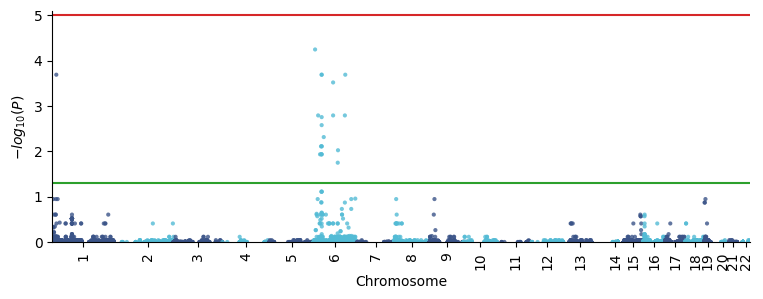

In [33]:
ax = manhattanplot(
    data=df_manhattan,
    genomewideline=0.05,
    xticklabel_kws={"rotation": "vertical"})

Zoom in on chromosomes

In [39]:
chromosome = 6

In [40]:
df_chrom = df_manhattan[df_manhattan["#CHROM"] == str(chromosome)]
len(df_chrom)

222343

/home/junkhann/.venv/lib/python3.10/site-packages/qmplot/modules/_manhattan.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[chrom]] = data[[chrom]].astype(str)  # make sure all the chromosome id are character.
/home/junkhann/.venv/lib/python3.10/site-packages/qmplot/modules/_manhattan.py:320: RuntimeWarning: divide by zero encountered in log10
  ax.axhline(y=-np.log10(suggestiveline) if logp else suggestiveline, color=sign_line_cols[0], **hline_kws)


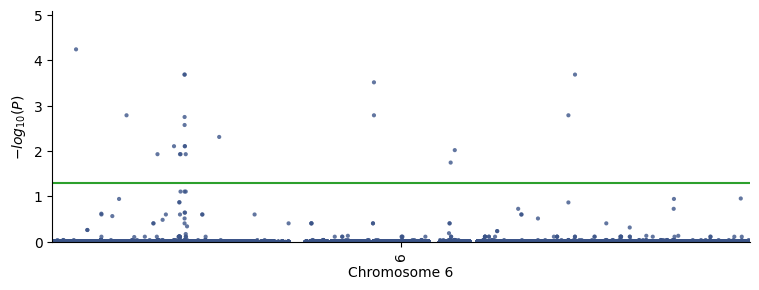

In [47]:
ax = manhattanplot(
    data=df_chrom,
    xticklabel_kws={"rotation": "vertical"}, 
    genomewideline=0.05,
    is_annotate_topsnp=True,
    suggestiveline=False,
    xlabel=f"Chromosome {chromosome}")

Get genomic region on chromosomes

In [44]:
df_region = df_manhattan[df_manhattan["#CHROM"] == str(chromosome)]
df_region = df_region[df_region["P"] < 0.05]
min_pos = df_region["POS"].min()
max_pos = df_region["POS"].max()

In [45]:
min_pos, max_pos

(5853468, 128106408)

Volcano plot

In [24]:
def get_log_score(df_position: pd.DataFrame) -> float:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_alt_alleles"] == "0"]
    ref = len(df_loss_ref)
    alt = n - ref
    if alt == 0 or ref == 0:
        log_score = float("nan")
    else:
        log_score = math.log10(ref / alt)
    return log_score

In [25]:
log_scores = df.groupby("position_code").apply(get_log_score)

In [26]:
log_scores

position_code
1-100000012   -0.255273
1-100000827   -0.204120
1-100002882   -0.204120
1-10000400     0.000000
1-100004726    0.000000
                 ...   
9-99105420     0.698970
9-993036      -0.079181
9-993760      -0.367977
9-99853127          NaN
9-99853128          NaN
Length: 490185, dtype: float64

In [27]:
df_volcano = pd.DataFrame(p_values).reset_index()
df_volcano["log_score"] = log_scores.values
df_volcano["adjusted p_val"] = adjusted_p_values
df_volcano = df_volcano.rename(columns={0: "p_value"})
df_volcano.head()

,position_code,p_value,log_score,adjusted p_val
0,1-100000012,0.423950,-0.255273,1.0
1,1-100000827,0.581055,-0.204120,1.0
2,1-100002882,0.581055,-0.204120,1.0
3,1-10000400,1.000000,0.000000,1.0
4,1-100004726,1.000000,0.000000,1.0


In [28]:
df_volcano = df_volcano.dropna(axis=0, subset=["log_score"])

In [30]:
visuz.GeneExpression.volcano(df=df_volcano, lfc='log_score', pv='adjusted p_val', show=True, axxlabel="log10(# ref alleles lost / # alt alleles lost)", plotlegend=True, legendlabels=["ref allele lost significantly less often", "not significant", "ref allele lost significantly more often"])

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes